### NLP REFERENCE: 
#### https://towardsdatascience.com/text-cleaning-methods-for-natural-language-processing-f2fc1796e8c7

In [1]:
import json
import tweepy
import csv
import re
import pandas as pd
import numpy as np
from textblob import TextBlob
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
cd /Users/abhishekshirsat/Desktop

/Users/abhishekshirsat/Desktop


In [3]:
log = pd.read_csv('Twitter_API_keys.csv')

In [4]:
mykey = log['Key'][0]
mysecret = log['Key'][1]
access_token = log['Key'][2]
access_token_Secret = log['Key'][3]

In [5]:
# Create authentication object
authenticate = tweepy.OAuthHandler(mykey, mysecret)

# Create access object
authenticate.set_access_token(access_token, access_token_Secret)

# Create API object
api = tweepy.API(authenticate, wait_on_rate_limit = True)

### Function to extract Tweets using Keyword / Phrase - tweepy.Cursor method - api.search (text_query) 

In [12]:
def get_related_tweets(text_query):
    twitter_users = []
    tweet_time = []
    tweet_string = [] 
    for tweet in tweepy.Cursor(api.search,q=text_query, count=1000).items(1000):
            if (not tweet.retweeted) and ('RT @' not in tweet.text):
                if tweet.lang == "en":
                    twitter_users.append(tweet.user.name)
                    tweet_time.append(tweet.created_at)
                    tweet_string.append(tweet.text)
                    #print([tweet.user.name,tweet.created_at,tweet.text])
    df = pd.DataFrame({'name':twitter_users, 'time': tweet_time, 'tweet': tweet_string})
    
    return df 

In [13]:
get_related_tweets('Wildfires 2020')

,name,time,tweet
0,Carlos Martín,2020-11-02 20:14:40,"The effects of disasters on people's budgets, ..."
1,Lauren Anderson,2020-11-02 20:07:19,"""For decades, Oregon’s timber industry has pro..."
2,EDF Growing Returns,2020-11-02 20:05:10,Powerful new web app will make critical water ...
3,Western Priorities,2020-11-02 20:02:00,“Fire season is not over in northern Colorado....
4,Life From The Ashes,2020-11-02 20:00:14,Did You Know More than 4 Million Acres Have Be...
...,...,...,...
390,The Circle Up Experience,2020-10-31 19:14:34,What is it about the stories of people helping...
391,Shehzad Younis,2020-10-31 19:08:24,What Happens to Voting When There’s a Natural ...
392,NatureConservancy WA,2020-10-31 19:07:11,How many “once-in-a-lifetime” natural disaster...
393,Zusia:Dr Jackie Volk,2020-10-31 19:00:33,National Interagency Coordination Center and F...


### Step 1 - Normalization : The below function normalizes the text - i.e removes excessive 'noise' unwanted terms and symbols

In [15]:
def  clean_text(df, text_field, new_text_field_name):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    # remove numbers
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    
    return df

In [16]:
import nltk

### Step 2  - Removing stop words - The words are do not carry much information and are repeated in the text - USE NLTK library 

In [17]:
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abhishekshirsat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Stemming - reducing the word count and keeping 1 word for similar meaning words - Not used in the sentiment analysis function

In [18]:
from nltk.stem import PorterStemmer 
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')

def word_stemmer(text):
    stem_text = [PorterStemmer().stem(i) for i in text]
    return stem_text

# We need to create text token first before stemming 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/abhishekshirsat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Lemmetization - finding the core form of words by first creating text tokens

In [19]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/abhishekshirsat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
# Get a word count

def word_count(sentence):
    return len(sentence.split())

### Get Subjectivity, Polarity and the Analysis of the text

In [21]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

## Main function to
### 1. Extract the tweet using user input text query
### 2. Text cleaning using NLTK - Steps 1, 2 (3, 4 are optional and used to get max. used words count)
### 3. Plot the Subjectivity VS Polarity of tweets and 
### 4. Get Tweet counts - based on sentiment

In [36]:
def get_sentiment(text_query):
    df = get_related_tweets(text_query)
    df_clean = clean_text(df, 'tweet', 'clean_tweet')
    df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df_clean['sentiment'] = df_clean['clean_tweet'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)
    df_clean['Subjectivity'] = df_clean['clean_tweet'].apply(getSubjectivity)
    df_clean['Polarity'] = df_clean['clean_tweet'].apply(getPolarity)
    df_clean['Analysis'] = df_clean['Polarity'].apply(getAnalysis)
    df_clean['word count'] = df_clean['clean_tweet'].apply(word_count)
    df_clean['text_tokens'] = df_clean['clean_tweet'].apply(lambda x: word_tokenize(x))
    df_clean['text_tokens_stem'] = df_clean['text_tokens'].apply(lambda x: word_stemmer(x))
    df_clean['text_tokens_lemma'] = df_clean['text_tokens'].apply(lambda x: word_lemmatizer(x))
    fig = plt.figure(figsize = (16, 7), )
    ax0 = fig.add_subplot(1, 2, 1) 
    ax1 = fig.add_subplot(1, 2, 2)
    df_clean.plot(kind='scatter', x='Polarity', y='Subjectivity', color = 'blue', ax=ax0)
    df_clean['Analysis'].value_counts().plot(kind = 'barh', color = 'blue', ax = ax1)
    ax0.set_xlabel('Polarity', fontsize = 14)
    ax0.set_ylabel('Subjectivity', fontsize = 14)
    ax1.set_xlabel('Count of tweets', fontsize = 14)
    ax1.set_ylabel('Tweet Sentiment', fontsize = 14)
    fig.suptitle('Sentiment Analysis', fontsize=16)
    plt.savefig('Sentiment_nltk.png')

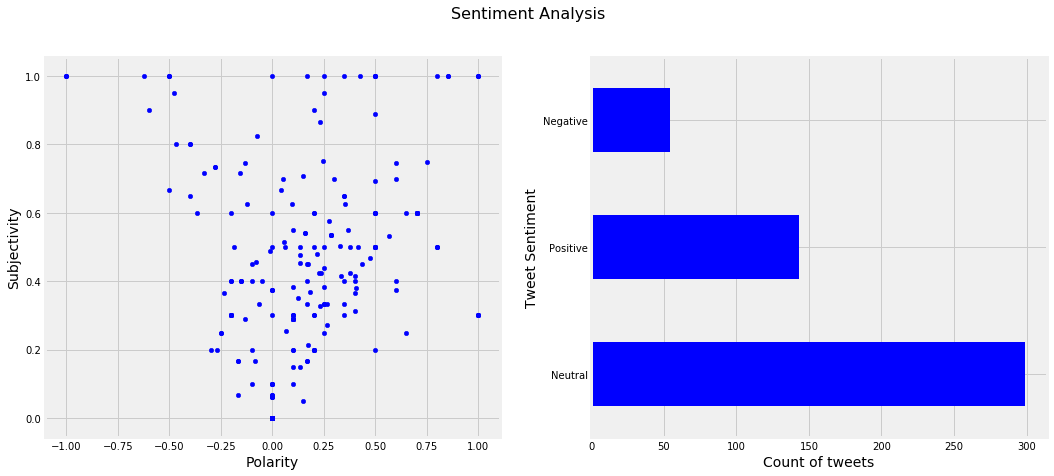

In [39]:
get_sentiment('Shawshank Redemption')